In [ ]:
# 지난 시간까지는 단순선형회귀
# 독립변수 한 개 : 결과값 y를 결정하는 요소(x)가 한 개

# 이제는 다중선형회귀
# 독립변수가 여러 개 : 결과값 y를 결정하는 요소(x)가 여러 개

In [ ]:
# 복습 : 단순선형회귀(Simple Linear Regression)

In [ ]:
# 예제 : 온도에 따른 오존량의 변화
# 데이터 : ozone.csv

In [3]:
# 1. 필요한 모듈 불러오기 
# tensorflow 활용, EDA 및 파일 불러오기 위해 pandas와 numpy, 그래프 그리기 위해 matplotlib.pyplot 활용
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# 동일 과정을 다른 모듈로 진행해보기 위해
# scipy : 과학적 연산 -> 선형회귀 결과값만 도출할 수 있음.
from scipy import stats
# scipy 패키지가 가진 여러 기능 중 통계 기능(module) 활용
# module not found 에러 : anaconda prompt창에서 일단 설치
# 명렁어 : pip install scipy
# conda 환경 사용하지만, scipy는 conda 명령어로 설치되지 않음 -> pip 기본 명령어로 설치.
# 사진 삽입!

ModuleNotFoundError: No module named 'scipy'

In [29]:
# 1. 데이터 불러오기(raw data loading)
# csv파일이므로, pandas 모듈 활용.
df = pd.read_csv("C:/Users/student/Desktop/data/ozone.csv")
display(df)                                                   # 잘 불러왔는지 확인.

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41.0,190.0,7.4,67,5,1
1,36.0,118.0,8.0,72,5,2
2,12.0,149.0,12.6,74,5,3
3,18.0,313.0,11.5,62,5,4
4,NaN,NaN,14.3,56,5,5
...,...,...,...,...,...,...
148,30.0,193.0,6.9,70,9,26
149,NaN,145.0,13.2,77,9,27
150,14.0,191.0,14.3,75,9,28
151,18.0,131.0,8.0,76,9,29


18.0 63.25
131.125


,Ozone,Temp,Temp_Norm,Ozone_Norm
0,41.0,67,0.250,0.330579
1,36.0,72,0.375,0.289256
2,12.0,74,0.425,0.090909
3,18.0,62,0.125,0.140496
5,28.0,66,0.225,0.223140
...,...,...,...,...
147,14.0,63,0.150,0.107438
148,30.0,70,0.325,0.239669
150,14.0,75,0.450,0.107438
151,18.0,76,0.475,0.140496


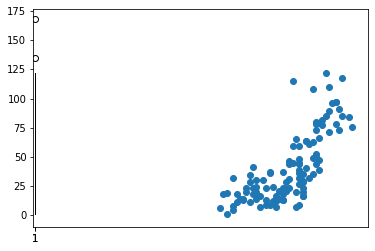

In [30]:
# 2. 전처리(data preprocessing)
# 학습에 적합한 데이터 형태로 만들기

# 2-1. 필요한 column 추출
# 학습에 필요하지 않은 변수 날리는 게 우선
df = df[["Ozone", "Temp"]]                                   # fancy indexing으로 필요한 column 추출.
df.head()                                                    # 필요한 column 추출되었는지 확인.
df.shape                                                     # (153행, 2열)

# 2-2. 결측치 처리
# 날리거나/대체하거나 등 여러 방식 있음.
# 일반적으로 대체하는 게 더 학습에 적합하나, 이 자료의 경우 대체할 값이 적절하지 않으므로 drop.
df = df.dropna(how = "any", inplace = False)                # 결측치 제거 -> 약 40개 가까이 날아감.
df.shape                                                    # (116행, 2열)                         

# 2-3. 이상치 처리
# 이상치 판단하는 여러 방식 중 Turkey Fence 방식(IQR기반) 이용.
# 이상치 존재한다면, 학습 시 내부적으로 이상치에 가중치가 부여되어 결과 왜곡.

# 1) 이상치 있는지 확인
plt.boxplot(df["Temp"])                                     # 온도에 대해서는 이상치 없음.
plt.boxplot(df["Ozone"])                                    # 오존에 대해서는 상위 이상치 존재함.

# 2) 이상치 제거
# 오존 변수에 존재하는 상위 이상치를 처리해야 함.
# IQR 이용해 상위, 하위 이상치의 경계값 계산.
q1, q3 = np.percentile(df["Ozone"], [25,75])                # 오존 변수에서 2개의 percentile값 추출.
print(q1, q3)                                               # tuple로 1사분위, 3사분위값 반환.
iqr = q3 - q1                                               
upper = q3 + 1.5 * iqr                                      # 상위이상치 boundary 공식
print(upper)                                                # 131.125 : 상위 이상치 처리 위한 경계값.
mask = df["Ozone"] > upper                                  # 상위 경계값 초과하는 값 찾음.
# broadcasting 진행되며 boolean mask가 생성됨.
df = df.loc[~mask]                                           # 행 추출: loc 
df.shape                                                    # (114g행 2열) : 이상치 2개 처리함.

# 3) 데이터 경향성 확인
# 다중선형회귀로 넘어가면 확인이 어려움.
# 어쨌든 여기서는,산점도(scatter) 이용해서 파악: 2차원.
plt.scatter(df["Temp"], df["Ozone"])                        # 데이터가 우상향형태를 보임.

# 4) 데이터 scale 변환
# 값의 수치 자체가 커서 학습이 잘 이루어지지 않음.
# 정형화 혹은 표준화를 이용해서 데이터 변화시킴.
# 정규화(normalization) = (요소값 - 최솟값) / (최댓값 - 최솟값) : 0과 1 사이의 값으로 계산됨.
# 표준화(standardization) = (요소값 -평균)/표쥰편차 :-1과 1 사이의 값.
# 어떤 방식을 이용하든 더 적합한 방식 찾아서 활용.
# 데이터를 학습에 좋은 형태로 만들어주면 됨.
# 일반적으로는 module을 이용했는데, 지난 번에는 프로그래밍 방식을 이용해 변수를 새로 만들어줬음.
df["Temp_Norm"] = (df["Temp"]-df["Temp"].min())/(df["Temp"].max()-df["Temp"].min())
df["Ozone_Norm"] = (df["Ozone"]-df["Ozone"].min())/(df["Ozone"].max()-df["Ozone"].min())
display(df)

# Q) 그림에 저기 동그라미 왜 있나??????????????????????????????????????????????????

In [46]:
# 3. 머신러닝(Tensorflow)

# 3-1. training data set
x_data = df["Temp_Norm"]                        # 정규화한 데이터를 잡아야 함.
y_data = df["Ozone_Norm"]                       # 해당 데이터에 대한 label.

# 3-2. placeholder
# 입력값을 넣기 위해 placeholder 이용.
# placeholder 목적: 1) training data를 받아들여서 학습. 2) 입력값 받아서 예측.
# placeholder를 이용하지 않으면 예측값 알아낼 때 오류 발생.
x = tf.placeholder(dtype = tf.float32)          # 독립변수 1개일 때는 data type만 맞춰서 보면 됨.
y = tf.placeholder(dtype = tf.float32)

# 3-3. weight, bias
# 초기에는 지정하기 어렵기 때문에, 난수값을 발생시킴.
# random_normal 안의 인자: 값을 몇 개 구하는지 넣어줌: shape 넣어줌.
# -> 단순 선형회귀일 때는 [1](1차원짜리 하나만 구해)
W = tf.Variable(tf.random_normal([1]), name = "weight") # 이름 : 내부적으로 변수를 어떠한 이름으로 사용할지.
b = tf.Variable(tf.random_normal([1]), name = "bias")

# 3-4. hypothesis
# 단순선형회귀 : 직선으로 표현됨.
H = W*x + b

# 3-5. cost function
# 최소제곱법을 이용해서 표현.
cost = tf.reduce_mean(tf.square(H-y))              # 가설에서 실제 데이터로 들어오는 y를 뺀 뒤 최소제곱합.

# 3-6. train
# 미분을 통해 cost 값이 최소가 되는 W, b 찾아야 함.
# 미분 과정을 수학식으로 쓰기보다는 tensorflow가 제공하는 알고리즘 활용.
# train node 만들어서 진행함.
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.01) # 알고리즘을 명시함.
# learning rate: 기울기를 얼마나 줄여가면서 학습을 진행할 것인지.
train = optimizer.minimize(cost) # 알고리즘을 실행함. train 한 번 실행하면 최소화작업 한 번 진행함.
# train 여러 번 진행하며 최적의 W, b 찾아가는 과정을 만들어야 함.

# 3-7. session, 초기화.
sess = tf.Session() # session 만들고
sess.run(tf.global_variables_initializer())  # 변수 초기화

# 3-8. 학습
# 반복적으로 학습 진행해야 하므로, 횟수 임의 지정.
# 각각의 node를 수행시켜서 학습 진행.
for step in range(3000):
    # sess.run(train)     # cost 값이 줄어들면서 최적의 W, b 찾는 학습이 진행될 것.
    # 그런데, 이렇게 하면 어떻게 학습이 진행되는지 알 수 없음.
    _, cost_val = sess.run([train, cost],
                          feed_dict = { x : x_data,
                                        y : y_data})
    # train 횟수와 cost의 값을 tuple형태로 뽑아내고
    # 무슨 값을 줄 것인지 feed_dict 인자 사용해서 지정함.
    
    if step % 300 == 0:
        print("cost값 : {}".format(cost_val))
    # 꼭 필요한 것은 아니지만, 눈으로 확인하면서 cost값이 줄어드는지 아닌지 확인하기 위해.
    
####################### 학습 완료 #############################
# 학습을 통해 최적의 W, b를 구함 -> H라는 가설을 완성한 것.

# 3-9. 예측(Prediction)
# 학습이 완료되었으니, 온도에 따라 오존량을 예측해야 함.
# 온도가 80(화씨)일 때의 오존량을 예측하고 싶다면?

# 1) 올바르지 않은 예측
print(sess.run(H, feed_dict = { x : 80 }))
# H라는 가설을 실행하고, x라는 값에 80을 feed.
# 그런데 이렇게 하면 올바른 예측이 아님.
# scale을 변화시켰기 때문에, 데이터의 범위가 0과 1 사이에 있어야 함.

# 2) 올바르게 예측하려면
# 2) -1. 예측하고 싶은 온도 값도 정규화.
tmp = (80 - df["Temp"].min())/(df["Temp"].max()-df["Temp"].min())
print(tmp) # 정규화된 80의 온도 값.
# 2) -2. 정규화된 온도를 가설에 넣어서 예측 진행.
print(sess.run(H, feed_dict = { x : tmp})) # 여기서 나온 ozone 값 역시 scale화된 값.
# 2) -3. 오존량의 예측치를 정규화되기 전의 상태로 원상복귀
result_scale = sess.run(H, feed_dict = { x : tmp})
result = result_scale * (df["Ozone"].max()-df["Ozone"].min()) + df["Ozone"].min()
print(result)
# 이렇게 해서 나온 게 제대로 예측한 값. 

cost값 : 9.246341705322266
cost값 : 0.04915507882833481
cost값 : 0.03970605507493019
cost값 : 0.034136995673179626
cost값 : 0.030854161828756332
cost값 : 0.02891901321709156
cost값 : 0.027778275310993195
cost값 : 0.027105845510959625
cost값 : 0.026709455996751785
cost값 : 0.026475798338651657
[57.25372]
0.575
[0.3650459]
[45.170555]


In [43]:
# 4. 다른 모듈을 이용해서 처리하려면?
# scipy 이용해서 이 과정 다시 진행
# scipy의 stats 모듈 이용해서 쉽게 처리할 수 있음.
# 이 방법 활용할 때에도 전처리는 필요함.
# 다만, normalization은 알아서 진행해줌.

from scipy import stats

x = df["Temp"]
y = df["Ozone"]

result = stats.linregress(x, y)
print(result)                       # slope : 위에서 구한 W, intercept : 위에서 구한 b.

# 온도가 80일 때 예측하면?
print(80*result[0] + result[1])
# result[0] = slope, result[1] = intercept(bias)

LinregressResult(slope=2.344807849550286, intercept=-142.19084219133276, rvalue=0.7515377011359844, pvalue=5.802324426210489e-22, stderr=0.19448560867502498)
45.39378577269011


In [ ]:
# 오늘의 내용: 다중선형회귀(Multiple Linear Regression)
# Label에 영향을 미치는 요소(변수)가 2개 이상인 경우.

In [47]:
# Hypothesis가 변경됨.
# 단순선형회귀의 가설 : H = W*x + b
# 다중선형회귀의 가설 : H = W1*x1 + W2*x2 + ... +Wn*xn + b
# Weight 및 변수가 여러 개이므로, matrix 형태로 W와 x를 표현. 
# 행렬을 활용하여 설명함. : 손필기?????????????????????????????
# H = matmul(X, W) + b => X, W는 행렬의 형태이고, matmul은 행렬의 곱!
# 들어오는 X 데이터가 가로로 되어있기 때문에, X를 앞으로 빼서 표현함.

In [ ]:
# 예제 : 퀴즈 성적을 이용한 최종 시험성적 예측
# 사용하는 데이터 
# 퀴즈1   퀴즈2   퀴즈3    최종성적
#  73      80      75        152
#  98      88      93        185
# 예측하고 싶은 데이터(label)는 최종성적.
# 세 번의 퀴즈에 대한 점수를 주면 최종 성적이 어떻게 될지 예측.
# 종속변수에 영향을 미치는 것은 퀴즈1~퀴즈3의 성적.

In [ ]:
# 1. training data set
# 다중선형회귀 모형에서는 data set의 차원이 달라짐.
# 다중선형회귀 모형에서는 x, y가 모두 2차원 matrix의 형태로 표현되어야 함.
# training data가 2차원이 되어야 하므로, list 안에 list를 넣어주어야 함.
x_data = [[73, 80, 75], 
          [98, 88, 93], 
          [89, 91, 90], 
          [96, 98, 100]]
y_data = [[152], [185], [180], [196]]


In [50]:
# 2. placeholder
# 다중선형회귀는 2차원 이상이므로, data type뿐만 아니라 shape도 잡아야 함.
# matrix이므로 X, Y, W 대문자(관용적).

# X = tf.placeholder(shape=[5, 3], dtype=tf.float32)
    # x_data의 data set의 형태를 shqpe 안에 넣어야 함.
    # 그래프를 그리기 위해 X라는 노드를 만드는 것.
    # x data가 그대로 X로 가서 박힘 -> 5행 3열이니까 그냥 그대로 써주면 됨.
    # 2차원이면 그냥 행, 열만 써주면 되었다!!! 행(차원), 열(차원)...
    # 그런데 X는 입력받는 데이터니까, 데이터 개수에 따라서 행이 변할 수 있음. 열은 변수니까 불변.
    # 앞에 5라고 행의 개수를 고정시켜버리면 prediction할 때 문제가 생긴다!
    # 한 가지 케이스만 넣고 싶은데, 5개의 데이터를 넣어서 예측해야 되는 것.

# placeholder 안에 shqpe에서 행을 지정해버리면(data의 개수) 안 됨.
# placeholder 목적: training data를 받아들여서 학습 // 입력값 받아서 예측
# 2차원일 때 입력 data가 2차원이 되므로, prediction할 때에 문제가 될 수 있음.
# 따라서 행의 개수는 결정하지 않음! 몇 개의 행이 들어오는지는 상관없고, 대신 열의 개수만(변수 개수) 맞춰라.

X = tf.placeholder(shape=[None, 3], dtype=tf.float32)                # X에 열 3개.
Y = tf.placeholder(shqpe=[None, 1], dtype=tf.float32)                # Y에 열 1개.

# shape 맞추는 게 까다롭다!
# data의 형태를 제대로 맞춰줘야 학습, 예측이 제대로 진행될 수 있음.

In [51]:
# 3. Weight, Bias 지정
# 손필기??????????????????????????????????????????????????????????
W = tf.Variable(tf.random_normal([3,1]), name = "weight") # 앞에 나온 data에 따라 W의 shape 바로 고정됨.
b = tf.Variable(tf.random_normal([1]), name = "bias")    # 상수는 어차피 1개 있으면 됨.

In [ ]:
# 4. Hypothesis 설정
# 유의 : 1) X가 먼저 온다(순서 주의!) 2) 행렬곱 연산이다(tensorflow 내의 matmul 함수!)
H = tf.matmul(X, W) + b

In [ ]:
# 5. Cost Function 설정
# 이 단계부터는 단순선형회귀 모형과 동일
# Q) y를 대문자로 행렬로 안 넣어도 되나????????????????????????????????????
cost = tf.reduce_mean(tf.square(H-y))

In [ ]:
# 예제 : ozone.csv
# Month, Day는 선형이 아니므로 학습에 활용할 수는 없음.
# Solar, Wind, Temp의 3가지 변수를 가지고 Ozone 예측에 활용할 것.

In [52]:
# 다중선형회귀 연습문제 -> practice 파일 참고.
# 관측된 Solar.R, Wind, Temp에 대한 Ozone량에 대한 데이터를 이용하여 machine learning을 진행하고
# Solar.R이 170, Wind가 7.4, Temp가 67.0일 때 Ozone 수치를 예측하자.

In [ ]:
==============================================================================================

In [53]:
# 연습문제 정답(에 가까운 답)을 알아보자.
# sklearn 모듈을 이용해서 학습시키고 예측까지 수행
# sklearn 패키지 안에 선형회귀를 구할 수 있는 모델이 따로 있음.
from sklearn import linear_model
# 아나콘다 프롬프트 창에서 pip 이용해서 pip install sklearn

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# 모델 만들고 데이터 줘서 학습시키고 그냥 모듈에 넣어서 해버리면 됨.
# 알고리즘 자체가 정해져 있음.
# Tensorflow로 값을 도출하고 맞는 값인지 아닌지 궁금할 때 sklearn에서 제공하는 모듈을 활용해서 답 보면 됨.

In [60]:
# 1. 필요한 모듈 불러오기
from sklearn import linear_model
import numpy as np
import pandas as pd

# 2. 데이터 불러오기
df = pd.read_csv("C:/Users/student/Desktop/data/ozone.csv")
df = df[["Ozone", "Solar.R", "Wind", "Temp"]]

# 3. EDA
df = df.dropna(how = "any", inplace = False)

q1, q3= np.percentile(df["Wind"], [25,75])
iqr = q3-q1
upper = q3 + 1.5*iqr
mask = df["Wind"] > upper                                  # 상위 경계값 초과하는 값 찾음.
# broadcasting 진행되며 boolean mask가 생성됨.
df = df.loc[~mask]                                           # 행 추출: loc 
df.shape                                                    # (114g행 2열) : 이상치 2개 처리함.

q1, q3= np.percentile(df["Ozone"], [25,75])
iqr = q3-q1
upper = q3 + 1.5*iqr
mask = df["Ozone"] > upper                                  # 상위 경계값 초과하는 값 찾음.
# broadcasting 진행되며 boolean mask가 생성됨.
df = df.loc[~mask]                                           # 행 추출: loc 
df.shape

display(df)

# 4. machine learning
# Tensorflow와 달리 shape 맞출 필요 없음.

# fancy indexing으로 df 잡아주기.
X = df[["Solar.R", "Wind", "Temp"]]
Y = df["Ozone"]

# linear model 만들기 : 알아서 만들어줌.
lm = linear_model.LinearRegression()
lm.fit(X,Y)

# 예측하기
# 예측할 때는 값을 제대로 넣어줘야 함. X 데이터가 data frame으로 들어가니까.
prediction = lm.predict([[170, 7.4, 67]])
print("예측 값은 {}".format(prediction))


,Ozone,Solar.R,Wind,Temp
0,41.0,190.0,7.4,67
1,36.0,118.0,8.0,72
2,12.0,149.0,12.6,74
3,18.0,313.0,11.5,62
6,23.0,299.0,8.6,65
...,...,...,...,...
147,14.0,20.0,16.6,63
148,30.0,193.0,6.9,70
150,14.0,191.0,14.3,75
151,18.0,131.0,8.0,76


예측 값은 [27.97594664]


In [68]:
# 표준화, 정규화 쉽게 하기
# sklearn package의 preprocessing 모듈 안에 MinMaxScaler 함수 활용
# 표준화/ 정규화를 먼저 하는 게 아니라, 머신러닝 단계에서 한 번에 처리한다.

# 1. 필요한 모듈 불러오기
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

# 2. data loading
df = pd.read_csv("C:/Users/student/Desktop/data/ozone.csv")

# 3. 결측치 제거
df = df.dropna(how = "any", inplace = False)

# 4. 이상치 제거
# 방법이 없다. 그냥 Turkey Fence 방식 계속.
df = df.dropna(how = "any", inplace = False)

q1, q3= np.percentile(df["Wind"], [25,75])
iqr = q3-q1
upper = q3 + 1.5*iqr
mask = df["Wind"] > upper                                 
df = df.loc[~mask]                                           
df.shape                                                   

q1, q3= np.percentile(df["Ozone"], [25,75])
iqr = q3-q1
upper = q3 + 1.5*iqr
mask = df["Ozone"] > upper                                  
df = df.loc[~mask]                                       
df.shape

# 5. 머신러닝 + 정규화
x_data = df[["Solar.R", "Wind", "Temp"]]
# 이 데이터로는 정규화가 되지 않았기 때문에 당연히 학습이 안 됨.
x_data = MinMaxScaler().fit_transform(x_data)  # 한 번에 정규화.
print(x_data)
y_data = df["Ozone"].values.reshape(-1,1)
y_data = MinMaxScaler().fit_transform(y_data)
print(y_data)

[[0.55963303 0.35664336 0.23076923]
 [0.33944954 0.3986014  0.35897436]
 [0.43425076 0.72027972 0.41025641]
 [0.93577982 0.64335664 0.1025641 ]
 [0.89296636 0.44055944 0.17948718]
 [0.28134557 0.8041958  0.02564103]
 [0.76146789 0.51748252 0.28205128]
 [0.86544343 0.48251748 0.20512821]
 [0.81651376 0.6013986  0.25641026]
 [0.17737003 0.76223776 0.        ]
 [1.         0.64335664 0.15384615]
 [0.91743119 0.67832168 0.20512821]
 [0.96330275 0.64335664 0.25641026]
 [0.11314985 0.51748252 0.1025641 ]
 [0.0030581  0.51748252 0.02564103]
 [0.95718654 1.         0.38461538]
 [0.05504587 0.51748252 0.07692308]
 [0.25993884 0.67832168 0.07692308]
 [0.01834862 0.67832168 0.23076923]
 [0.74923547 0.88111888 0.58974359]
 [0.66055046 0.23776224 0.53846154]
 [0.83180428 0.35664336 0.46153846]
 [0.36697248 0.51748252 0.61538462]
 [0.86850153 0.8041958  0.82051282]
 [0.96636086 0.64335664 0.74358974]
 [0.43119266 0.3986014  0.61538462]
 [0.56269113 0.88111888 0.48717949]
 [0.09174312 0.48251748 0.17